### Estructura del notebook

1. Introducción de librerias a utilizar y presentación inicial de los conjuntos de datos.
2. Respuesta a las preguntas 1 a 3. 
3. Analisis exploratorio del conjunto de datos Occupancy Detection (después de responder las primeras cuatro preguntas se llegó a la conclusión de que el conjunto de datos que podía garantizar generalización era el de Occupancy Detection por lo tanto es el enfoque del notebook y el unico que va a ser utilizado para continuar con las demás preguntas). 
4. Respuesta a las preguntas 4 a 6.
5. Aplicación del mismo problema usando Regresión logistica y Arboles de decisión. 

### Introducción

In [1]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn import datasets

# Primer dataset - Banknote authentication Data Set 
dfbn = pd.read_csv('data_banknote_authentication.txt', header=None, names = ['variance', 'skewness', 'curtosis', 'entropy', 
                                                                            'class'])

# Segundo dataset - Occupancy Detection Data Set
dfod_train = pd.read_csv('datatraining.txt', parse_dates = ['date'])
dfod_val = pd.read_csv('datatest.txt', parse_dates = ['date'])
dfod_test = pd.read_csv('datatest2.txt', parse_dates = ['date'])

In [2]:
dfbn.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
dfod_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### Analisis exploratorio del conjunto de datos Banknote authentication

Revisión de que tan balanceada estan las clases para este conjunto de datos

In [4]:
# Renombrando las clases
dfbn['class'] = dfbn['class'].replace({0: 'no authentic', 1: 'authentic'})

Text(0, 0.5, 'Cantidad')

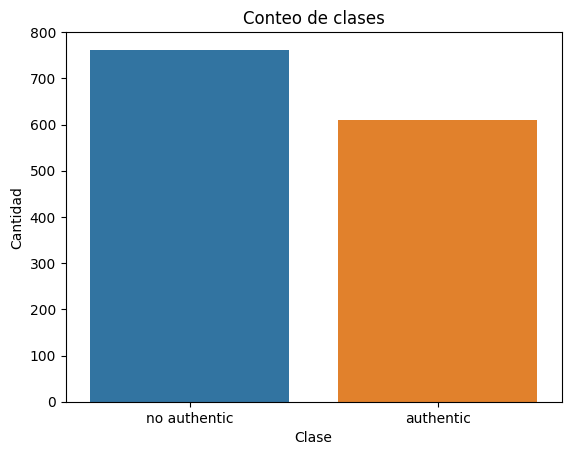

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=dfbn,x='class')
plt.title("Conteo de clases")
plt.xlabel('Clase')
plt.ylabel('Cantidad')

Ambas clases tienen un recuento parecido, por lo tanto el conjunto de datos tiene un buen balance de clases.

Estadisticos descriptivos de la data

In [6]:
dfbn.info()
dfbn.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   object 
dtypes: float64(4), object(1)
memory usage: 53.7+ KB


,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


Como podemos ver este conjunto de datos no tiene valores nulos, sin embargo se ve que necesario normalizar las columnas. Primero se dividir el conjunto de datos en el set de entrenamiento y prueba (no se agrega validación debido a la cantidad limitada de registros) y luego se procederá con la normalización. 

In [7]:
# Dividimos el conjunto de datos en train y prueba
Xbn = dfbn.drop(['class'], axis=1)
ybn = dfbn['class']
Xbn_train, Xbn_test, ybn_train, ybn_test = train_test_split(Xbn, ybn, test_size=0.33, random_state=42)

In [8]:
# Normalización de los datos con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Se entrena el MinMaxScaler usando el conjunto de datos de entrenamiento
columns = ['variance','skewness', 'curtosis', 'entropy']
scaler.fit(np.array(Xbn_train[columns]))

# Se aplica el MinMaxScaler los dos conjuntos de datos
Xbn_train[columns] = scaler.transform(np.array(Xbn_train[columns]))
Xbn_test[columns] = scaler.transform(np.array(Xbn_test[columns]))

### Analisis exploratorio del conjunto de datos Occupancy Detection 

Este conjunto de datos contiene datos experimentales de mediciones de luz, temperatura, humedad y CO2 para detectar la ocupación de una sala de oficina; es importante determinar de forma precisa la ocupación de un edificio/sala/oficina porque se ha estimado que puede ahorra energía en el orden del 30 al 42%.

A continuación se muestran las variables que componen el conjunto de datos: 
- date: Momento en el que se tomó la imagen.
- temperature: Temperatura del cuarto medida en grados Celcius
- Relative Humidity: Humedad relativa la cual es medida en porcentaje.
- Light: Iluminación en lux, es la cantidad de luz que pasa a través de una superficie y es medido Lux.
- Occupancy: Ocupación, 0 ó 1, 0 es el estado NO ocupado y 1 es el estado ocupado.

A continuación se muestra los estadisticos descriptivos de la data

In [9]:
dfod_train.info()
dfod_train.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           8143 non-null   datetime64[ns]
 1   Temperature    8143 non-null   float64       
 2   Humidity       8143 non-null   float64       
 3   Light          8143 non-null   float64       
 4   CO2            8143 non-null   float64       
 5   HumidityRatio  8143 non-null   float64       
 6   Occupancy      8143 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 508.9+ KB


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [10]:
# Organización del dataset y cambios de nombre a las clases 
# El set de datos 2 ya viene dividido en el conjunto de datos de entrenamiento, validacion y prueba

dfod_train.columns = dfod_train.columns.str.lower()
dfod_train['occupancy'] = dfod_train['occupancy'].replace({0: 'no', 1: 'yes'})

dfod_val.columns = dfod_val.columns.str.lower()
dfod_val['occupancy'] = dfod_val['occupancy'].replace({0: 'no', 1: 'yes'})

dfod_test.columns = dfod_test.columns.str.lower()
dfod_test['occupancy'] = dfod_test['occupancy'].replace({0: 'no', 1: 'yes'})

Vamos a revisar el balance de las clases en el conjunto de entrenamiento

Text(0, 0.5, 'Cantidad')

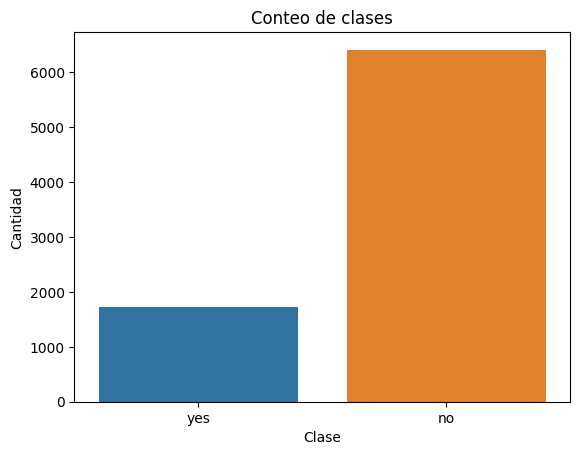

In [11]:
sns.countplot(data=dfod_train,x='occupancy')
plt.title("Conteo de clases")
plt.xlabel('Clase')
plt.ylabel('Cantidad')

Hay un alto desbalanceo de las clases por lo cual se va a remuestrear el conjunto de datos eliminando las instancias de la clase mayoritaria (no ocupado o 0)

In [12]:
dfod_train.head(20)

,date,temperature,humidity,light,co2,humidityratio,occupancy
1,2015-02-04 17:51:00,23.180,27.272000,426.0,721.250000,0.004793,yes
2,2015-02-04 17:51:59,23.150,27.267500,429.5,714.000000,0.004783,yes
3,2015-02-04 17:53:00,23.150,27.245000,426.0,713.500000,0.004779,yes
4,2015-02-04 17:54:00,23.150,27.200000,426.0,708.250000,0.004772,yes
5,2015-02-04 17:55:00,23.100,27.200000,426.0,704.500000,0.004757,yes
6,2015-02-04 17:55:59,23.100,27.200000,419.0,701.000000,0.004757,yes
7,2015-02-04 17:57:00,23.100,27.200000,419.0,701.666667,0.004757,yes
8,2015-02-04 17:57:59,23.100,27.200000,419.0,699.000000,0.004757,yes
9,2015-02-04 17:58:59,23.100,27.200000,419.0,689.333333,0.004757,yes
10,2015-02-04 18:00:00,23.075,27.175000,419.0,688.000000,0.004745,yes


In [13]:
# Hago el downsample disminuyendo la frecuencia de los datos de segundos a 5 min 
dfod_train.set_index('date', inplace=True)
dfod_train = dfod_train.groupby('occupancy').resample('1Min').sum().reset_index()

C:\Users\Maria Perpiñan\AppData\Local\Temp\ipykernel_9292\1634743132.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfod_train = dfod_train.groupby('occupancy').resample('1Min').sum().reset_index()


Text(0, 0.5, 'Cantidad')

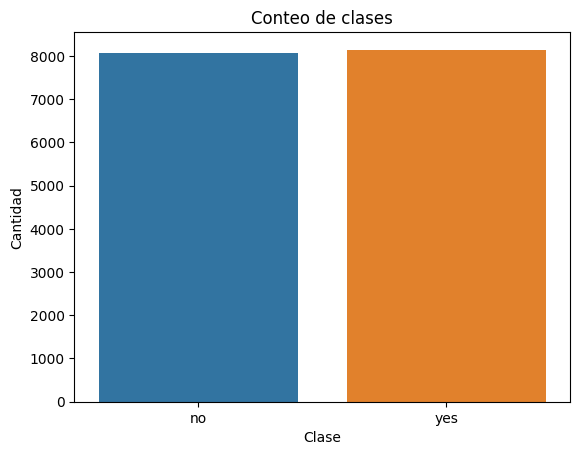

In [14]:
sns.countplot(data=dfod_train,x='occupancy')
plt.title("Conteo de clases")
plt.xlabel('Clase')
plt.ylabel('Cantidad')

Al igual que en el primer conjunto de datos no tenemos valores nulos; dado que tenemos valores bajos de de humedad relativa y valores altos como la luz y el CO2 debemos normalizar los datos para simplificar y mejorar el proceso de aprendizaje.

In [15]:
columns = ['temperature', 'humidity', 'light', 'co2', 'humidityratio']

# Se entrena el MinMaxScaler usando el conjunto de datos de entrenamiento
scaler.fit(np.array(dfod_train[columns]))

# Se aplica el MinMaxScaler todas los conjuntos de datos
dfod_train[columns] = scaler.transform(np.array(dfod_train[columns]))
dfod_val[columns] = scaler.transform(np.array(dfod_val[columns]))
dfod_test[columns] = scaler.transform(np.array(dfod_test[columns]))

dfod_train.describe()

,temperature,humidity,light,co2,humidityratio
count,16218.000000,16218.000000,16218.000000,16218.000000,16218.000000
mean,0.223457,0.165198,0.020016,0.075131,0.149781
std,0.298806,0.228351,0.060545,0.119302,0.207379
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.441291,0.335582,0.000000,0.112002,0.293857
max,1.000000,1.000000,1.000000,1.000000,1.000000


Se va a realizar un tratamiento al periodo de tiempo el cual se va a manejar en horas y en días de semana

In [16]:
import datetime

In [17]:
def convert_hour_to_word(hour):
    hour = hour % 24  # Ensure the hour value is within 0-23 range
    time = datetime.time(hour=hour)
    hour_word = time.strftime("%I %p")  # Convert hour to "hh AM/PM" format
    hour_word = hour_word.lstrip("0")  # Remove leading zero from single-digit hours
    return hour_word

In [18]:
def convert_minute_to_word(minute):
    minute = minute % 60  # Ensure the minute value is within 0-59 range
    time = datetime.time(hour=0, minute=minute)
    minute_word = time.strftime("%M")
    minute_word = minute_word.lstrip("0")  # Remove leading zero from single-digit minutes
    minute_word += " Min"
    return minute_word

In [19]:
"""# Aplicación conjunto de datos de entrenamiento
dfod_train['week_day'] = dfod_train['date'].dt.day_name()
dfod_train['hour'] = dfod_train['date'].dt.hour
dfod_train['minute'] = dfod_train['date'].dt.minute
dfod_train['hour'] = dfod_train['hour'].apply(convert_hour_to_word)
dfod_train['minute'] = dfod_train['minute'].apply(convert_minute_to_word)


dfod_val['week_day'] = dfod_val['date'].dt.day_name()
dfod_val['hour'] = dfod_val['date'].dt.hour
dfod_val['minute'] = dfod_val['date'].dt.minute
dfod_val['hour'] = dfod_val['hour'].apply(convert_hour_to_word)
dfod_val['minute'] = dfod_val['minute'].apply(convert_minute_to_word)


dfod_test['week_day'] = dfod_test['date'].dt.day_name()
dfod_test['hour'] = dfod_test['date'].dt.hour 
dfod_test['minute'] = dfod_test['date'].dt.minute
dfod_test['hour'] = dfod_test['hour'].apply(convert_hour_to_word)
dfod_test['minute'] = dfod_test['minute'].apply(convert_minute_to_word)

from sklearn.preprocessing import LabelEncoder

dfod_train[['week_day', 'hour', 'minute']] = dfod_train[['week_day', 'hour', 'minute']] .apply(LabelEncoder().fit_transform)
dfod_val[['week_day', 'hour', 'minute']] = dfod_val[['week_day', 'hour', 'minute']] .apply(LabelEncoder().fit_transform)
dfod_test[['week_day', 'hour', 'minute']] = dfod_test[['week_day', 'hour', 'minute']] .apply(LabelEncoder().fit_transform)"""

"# Aplicación conjunto de datos de entrenamiento\ndfod_train['week_day'] = dfod_train['date'].dt.day_name()\ndfod_train['hour'] = dfod_train['date'].dt.hour\ndfod_train['minute'] = dfod_train['date'].dt.minute\ndfod_train['hour'] = dfod_train['hour'].apply(convert_hour_to_word)\ndfod_train['minute'] = dfod_train['minute'].apply(convert_minute_to_word)\n\n\ndfod_val['week_day'] = dfod_val['date'].dt.day_name()\ndfod_val['hour'] = dfod_val['date'].dt.hour\ndfod_val['minute'] = dfod_val['date'].dt.minute\ndfod_val['hour'] = dfod_val['hour'].apply(convert_hour_to_word)\ndfod_val['minute'] = dfod_val['minute'].apply(convert_minute_to_word)\n\n\ndfod_test['week_day'] = dfod_test['date'].dt.day_name()\ndfod_test['hour'] = dfod_test['date'].dt.hour \ndfod_test['minute'] = dfod_test['date'].dt.minute\ndfod_test['hour'] = dfod_test['hour'].apply(convert_hour_to_word)\ndfod_test['minute'] = dfod_test['minute'].apply(convert_minute_to_word)\n\nfrom sklearn.preprocessing import LabelEncoder\n\ndfod

In [20]:
dfod_train

,occupancy,date,temperature,humidity,light,co2,humidityratio
0,no,2015-02-04 18:07:00,0.496439,0.347793,0.000000,0.168126,0.365161
1,no,2015-02-04 18:08:00,0.990503,0.699166,0.000000,0.337980,0.731652
2,no,2015-02-04 18:09:00,0.000000,0.000000,0.000000,0.000000,0.000000
3,no,2015-02-04 18:10:00,0.988129,0.700444,0.000000,0.340076,0.730543
4,no,2015-02-04 18:11:00,0.494064,0.350222,0.000000,0.169977,0.365272
...,...,...,...,...,...,...,...
16213,yes,2015-02-10 09:29:00,0.908698,0.921811,0.288851,0.388985,0.860482
16214,yes,2015-02-10 09:30:00,0.455428,0.461529,0.144426,0.196990,0.432165
16215,yes,2015-02-10 09:31:00,0.000000,0.000000,0.000000,0.000000,0.000000
16216,yes,2015-02-10 09:32:00,0.455428,0.463638,0.144426,0.202377,0.434159


In [21]:
# Aplicación conjunto de datos de entrenamiento
dfod_train['week_day'] = dfod_train['date'].dt.weekday 
dfod_train['hour'] = dfod_train['date'].dt.hour
dfod_train['minute'] = dfod_train['date'].dt.minute

# Aplicación a los demás conjuntos de datos
dfod_val['week_day'] = dfod_val['date'].dt.weekday
dfod_val['hour'] = dfod_val['date'].dt.hour
dfod_val['minute'] = dfod_val['date'].dt.minute

dfod_test['week_day'] = dfod_test['date'].dt.weekday
dfod_test['hour'] = dfod_test['date'].dt.hour 
dfod_test['minute'] = dfod_test['date'].dt.minute

#NOTA: Lunes es el día 0 y Domingo es el 6

In [22]:
dfod_test.head()

,date,temperature,humidity,light,co2,humidityratio,occupancy,week_day,hour,minute
1,2015-02-11 14:48:00,0.469674,0.398086,0.145871,0.254019,0.387785,yes,2,14,48
2,2015-02-11 14:49:00,0.470322,0.396381,0.145871,0.246700,0.386825,yes,2,14,49
3,2015-02-11 14:50:00,0.469836,0.397948,0.144759,0.247626,0.387829,yes,2,14,50
4,2015-02-11 14:51:00,0.469836,0.397948,0.146427,0.249044,0.387829,yes,2,14,51
5,2015-02-11 14:51:59,0.470322,0.398086,0.145871,0.248098,0.388503,yes,2,14,51


In [23]:
dfod_val.head()

,date,temperature,humidity,light,co2,humidityratio,occupancy,week_day,hour,minute
140,2015-02-02 14:19:00,0.511548,0.335927,0.195191,0.184828,0.367948,yes,0,14,19
141,2015-02-02 14:19:59,0.511936,0.336157,0.192923,0.187591,0.368605,yes,0,14,19
142,2015-02-02 14:21:00,0.512195,0.335390,0.191011,0.189877,0.368025,yes,0,14,21
143,2015-02-02 14:22:00,0.512033,0.334047,0.164689,0.191131,0.366374,yes,0,14,22
144,2015-02-02 14:23:00,0.512713,0.335006,0.162971,0.192180,0.368136,yes,0,14,23


Separamos las variables predictoras (X) y de respuesta (Y) de cada conjunto de datos

In [24]:
Xfod_train = dfod_train.drop(['occupancy', 'date'], axis=1).to_numpy()
yfod_train = dfod_train['occupancy'].to_numpy()
Xfod_test = dfod_test.drop(['occupancy', 'date'], axis=1).to_numpy()
yfod_test = dfod_test['occupancy'].to_numpy()
Xfod_val = dfod_val.drop(['occupancy', 'date'], axis=1).to_numpy()
yfod_val = dfod_val['occupancy'].to_numpy()

### Funcionamiento del código SVM

### Aplicación SVM a conjuntos de datos

In [25]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
clf = svm.SVC()

### Banknote authentication 

In [37]:
clf.fit(Xbn_train, ybn_train)
pred_test = clf.predict(Xbn_test)

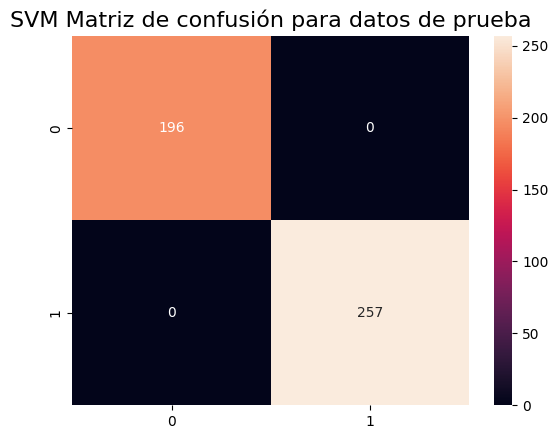

In [38]:
plt.title("SVM Matriz de confusión para datos de prueba", fontdict={'fontsize':16})
ax = sns.heatmap(confusion_matrix(ybn_test, pred_test), annot=True, fmt="d")

In [28]:
accuracy_test = accuracy_score(ybn_test, pred_test)
print(f"Exactitud en datos de prueba: {accuracy_test*100:.2f}%")

Exactitud en datos de prueba: 100.00%


### Occupancy Detection

In [41]:
clf = svm.SVC()
clf.fit(Xfod_train, yfod_train)

pred_val = clf.predict(Xfod_val)
pred_test = clf.predict(Xfod_test)

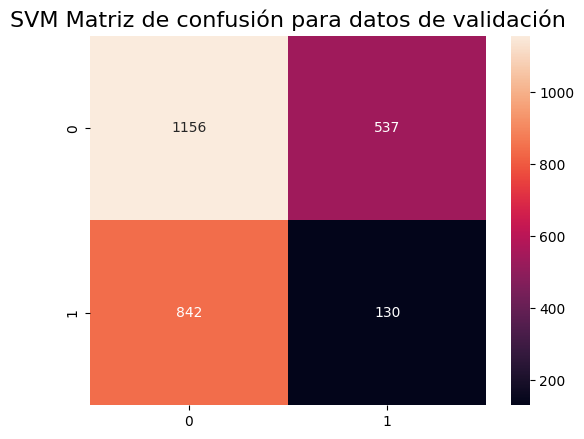

In [42]:
plt.title("SVM Matriz de confusión para datos de validación", fontdict={'fontsize':16})
ax = sns.heatmap(confusion_matrix(yfod_val, pred_val), annot=True, fmt="d")

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [44]:
accuracy_val = accuracy_score(yfod_val, pred_val)
print(f"Exactitud en datos de validación: {accuracy_val*100:.2f}%")

Exactitud en datos de validación: 48.26%


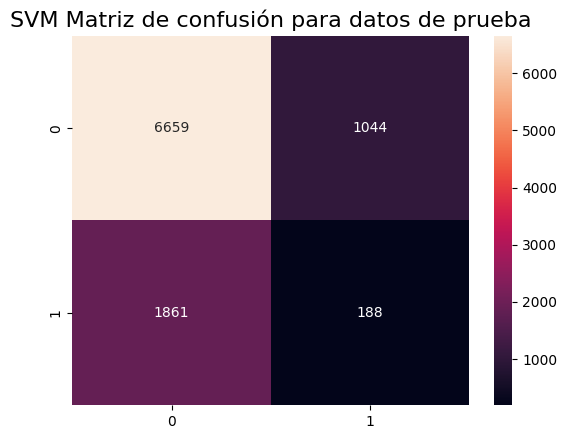

In [45]:
plt.title("SVM Matriz de confusión para datos de prueba", fontdict={'fontsize':16})
ax = sns.heatmap(confusion_matrix(yfod_test, pred_test), annot=True, fmt="d")

In [34]:
accuracy_test = accuracy_score(yfod_test, pred_test)
print(f"Exactitud en datos de prueba: {accuracy_test*100:.2f}%")

Exactitud en datos de prueba: 70.21%
